In [1]:
import librosa
import numpy as np
from scipy.signal import get_window 

from my_windowing import my_windowing

wave_files = [
    "Audio/phone.wav",
    "Audio/speech1.wav"
]

In [2]:
def compute_stft(
        v_signal: np.ndarray, 
        fs: int, 
        frame_length: int, 
        frame_shift: int, 
        v_analysis_window: np.ndarray) : #-> [np.ndarray (m_stft), np.ndarray (v_freq), np.ndarray (v_time)]:
    """
    Input:
    - v_signal vector containing the time domain signal
    - fs sampling rate in Hz
    - frame_length frame length in milliseconds
    - frame_shift frame shift in milliseconds
    - v_analysis_window vector that contains the spectral analysis window (This vector should have the same length as the frames, i.e., frame_length in samples.)
    Output:
    - m_stft a matrix which stores the complex short-time spectra in each row
    - v_freq a vector which contains the frequency axis (in units of Hertz) corresponding to the computed spectra
    - v_time time steps around which a frame is centered (as in previous exercise)
    """
    samples_per_frame = int(fs * frame_length / 1000)

    if len(v_analysis_window) != samples_per_frame:
        raise ValueError("v_analysis_window invalid length")
    # 1. Split the time domain signal into overlapping blocks
    m_frames, v_time_frames = my_windowing(v_signal, fs, frame_length, frame_shift)
    # 2. Apply the analysis window to each segment of the time domain signal
    m_frames = m_frames * v_analysis_window # ifftshift ?
    # 3. Use the fft function provided by np.fft to compute the DFT for each windowed segment
    dft = np.fft.fft(m_frames, axis=1)
    # 4. Only keep the lower half of the spectrum and remove the upper half. Make sure that the frequency bin at the Nyquist frequency is still included
    num_freq_bins = dft.shape[1]
    
    if num_freq_bins % 2 == 0:  # Even number of bins
        dft = dft[:, :num_freq_bins//2 + 1]
    else:  # Odd number of bins
        dft = dft[:, :(num_freq_bins + 1)//2]
    
    # 5. Store the transformed frames in the rows of the output matrix m_stft
    m_stft = dft

    # Test
    rfft = np.fft.rfft(m_frames, axis=1)
    np.testing.assert_array_almost_equal(m_stft, rfft)

    return m_stft

y, sr = librosa.load(wave_files[0], sr=None)

samples_per_frame = int(sr * 32 / 1000)
v_analysis_window = get_window("hann", samples_per_frame, True)

m_stft = compute_stft(y, sr, 32, 8, v_analysis_window)


*Why are the computed spectra complex conjugate symmetric?*

Complex Conjugate: $3*3+1 = 3*3-i$
Let ... be a real-valued signal with $N$ samples.
Then the DFT series ... has conjugate symmetry:
...


*What may be the advantage of only considering one half of the spectrum?*

The advantage of only considering one half of the spectrum is to reduce redundancy and save memory/storage space. 
Since the negative frequencies are symmetrical to the positive frequencies for a real-valued signal, only storing 
the positive frequencies is sufficient.

*How can you compute the frequency for each spectral bin? How many sampling points does the*

*spectrum have after you removed the mirrored part while including the Nyquist frequency bin?*

The frequency for each spectral bin can be computed using `np.fft.rfftfreq`. After removing 
 the mirrored part while including the Nyquist frequency bin, the spectrum will have `(frame_length_samples // 2) + 1` sampling points.

**2 Spectral analysis**


If not stated otherwise, the following exercises should be performed for both signals.
a) Use your own function to compute the STFT and plot the logarithmic magnitude spectrogram in dB using
the following parameters.

- frame length: 32 ms
- frame shift: 8 ms
- window function: periodic Hann window

You can create the Hann window with v_analysis_window = get_window('hann', frame_length_samples,
periodic=True) using scipy.signal.get_window where frame_length_samples is the frame length in samples.
The spectrogram can be plotted using the matplotlib.pyplot.imshow function:
```python
fig = plt.figure ()
ax = fig.add_subplot (111)
im = ax.imshow (10*np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**( -15))),
cmap='viridis ', origin='lower', extent =[ v_time [0], v_time[-1], v_freq [0],
v_freq [-1]], aspect='auto')
fig.colorbar(im , orientation="vertical", pad =0.2)
```

The extent option tells matplotlib to use the entries of the vector v_time for the x-axis and v_freq for the
y-axis. Here, the vector v_time contains the time instants for each block / each spectrum and the vector
v_freq contains the frequency bin information.
•Why is the magnitude plotted in dB? Why is it reasonable to introduce a lower limit? What is the lower
limit in the command given above in dB?
b) Identify the voiced, unvoiced and silence segments in the spectrogram of the speech signal by eye.
•Describe their appearance and what distinguishes them. Is it possible to identify the different voicing
types more easily in comparison to the time domain representation?
c) Produce the same plot as in a) but this time using a frame length corresponding to 8 ms and a frame shift of
2 ms. Further, create a plot for a frame length of 128 ms and a frame shift of 32 ms.
•How well can you distinguish single sinusoidal components? Short impulses? Explain the influence of
the different parameter settings.
d) Only for the speech signal estimate the fundamental frequency using the auto-correlation-based method of
the last exercise session. Plot the estimated fundamental frequency onto the spectrogram. The parameter
setting should be the one used in a). This can be achieved calling matplotlib.pyplot.plot on the the same
axis instance (variable named ax in the code snippet above).
•Do the estimated fundamental frequencies follow the harmonic structures in the spectrogram? You
may also want to plot higher harmonics by multiplying your estimated fundamental frequencies with a
positive integer value. This way, you can see the precision of the estimated frequencies more precisely.
2


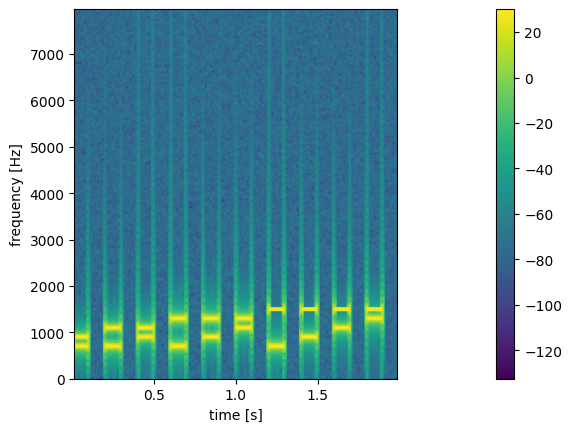

In [4]:
import matplotlib.pyplot as plt


def plot_log_magnitude(m_stft: np.ndarray, v_time: np.ndarray):
    num_points = m_stft.shape[1]
    v_freq = np.fft.rfftfreq(num_points, d=1/sr)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylabel("frequency [Hz]")
    ax.set_xlabel("time [s]")
    im = ax.imshow(
        10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15))),
        cmap="viridis",
        origin="lower",
        extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
        aspect="auto",
    )
    fig.colorbar(im, orientation="vertical", pad=0.2)


y, sr = librosa.load(wave_files[0], sr=None)

# Input Parameter
frame_length_ms = 32
frame_shift_ms = 8
v_analysis_window = get_window("hann", int(sr * 32 / 1000), True)

m_frames, v_time_frames = my_windowing(y, sr, frame_length_ms, frame_shift_ms)
m_stft = compute_stft(y, sr, 32, 8, v_analysis_window)


plot_log_magnitude(m_stft, v_time_frames)
